In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np


from tyssue import config
from tyssue.draw import sheet_view

# Geometry classes

A `Geometry` class is a stateless class holding functions to compute geometrical aspects of an epithelium,
such as the edge lengths or the cells volume. As they are classes, inheritance can be used to define more and more specialized geometries.

For the user, a geometry class is expected to have an `update_all` method that takes an `Epithelium` instance as sole argument.


## Planar Geometries 

It's simple to create hexagonal apical junction meshes with the `Sheet` class method `planar_sheet_2d()`:

In [1]:
from tyssue import Sheet
from tyssue import PlanarGeometry
from tyssue.generation import generate_ring

sheet_2d = Sheet.planar_sheet_2d('planar', nx=6, ny=6, 
                                 distx=1, disty=1)
sheet_2d.sanitize(trim_borders=True, order_edges=True)

PlanarGeometry.update_all(sheet_2d)

ring = generate_ring(24, 12, 14)
PlanarGeometry.update_all(ring)


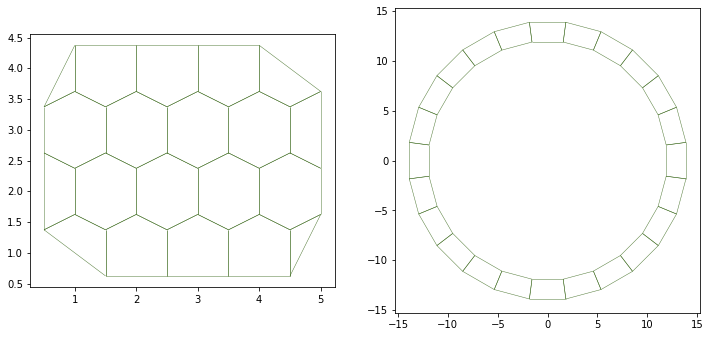

In [4]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig, ax = sheet_view(sheet_2d, ax=ax)
fig, ax2 = sheet_view(ring, ax=ax2)
fig.set_size_inches(12, 6)


## Sheet geometry in 3D

In [5]:
from tyssue import SheetGeometry
from tyssue.geometry.sheet_geometry import EllipsoidGeometry
from tyssue.generation import ellipsoid_sheet

sheet_3d = Sheet.planar_sheet_3d('sheet', nx=6, ny=6, 
                                 distx=1, disty=1)
sheet_3d.sanitize(trim_borders=True)

SheetGeometry.update_all(sheet_3d)

ellipso = ellipsoid_sheet(a=12, b=12, c=21, n_zs=12)
EllipsoidGeometry.update_all(ellipso)

In [6]:
sheet_3d.vert_df.head()

,y,is_active,x,z,rho,height,basal_shift
vert,,,,,,,
0,2.625,1,0.5,0,0,-4.0,4.0
1,3.375,1,1.5,0,0,-4.0,4.0
2,2.625,1,2.5,0,0,-4.0,4.0
3,3.375,1,0.5,0,0,-4.0,4.0
4,3.625,1,1.0,0,0,-4.0,4.0


`EllipsoidGeometry` inherits from `SheetGeometry` through `ClosedSheetGeometry`:

In [7]:
import inspect
print(*(cls.__name__ for cls in 
        inspect.getmro(EllipsoidGeometry)), sep="\n\t|_ ")

EllipsoidGeometry
	|_ ClosedSheetGeometry
	|_ SheetGeometry
	|_ PlanarGeometry
	|_ BaseGeometry
	|_ object


In [8]:
for i, cls in enumerate(inspect.getmro(EllipsoidGeometry)):
    print(cls.__name__, "which defines:")
    
    for method, _ in inspect.getmembers(cls, inspect.ismethod):
        print("\t", method)
    if cls.__name__ == "BaseGeometry":
        break
    print("inherits from", end=" ")


EllipsoidGeometry which defines:
	 face_rotations
	 get_phis
	 reset_scafold
	 update_all
inherits from ClosedSheetGeometry which defines:
	 face_rotations
	 get_phis
	 reset_scafold
	 update_all
	 update_height
inherits from SheetGeometry which defines:
	 face_rotations
	 get_phis
	 reset_scafold
	 update_all
	 update_height
inherits from PlanarGeometry which defines:
	 get_phis
	 update_all
inherits from BaseGeometry which defines:


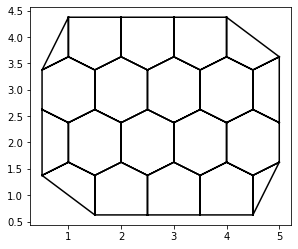

In [9]:
fig, ax = sheet_view(sheet_3d, ["x", "y"], 
                     mode="quick", edge={"color": 'k'})

In [10]:
from tyssue.draw.ipv_draw import view_ipv
import ipyvolume as ipv
ipv.clear()

fig, mesh = sheet_view(ellipso, mode="3D")
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

## Monolayer 

In [11]:
from tyssue import Monolayer
from tyssue.generation import extrude

extruded = extrude(sheet_3d.datasets, method='translation')
specs = config.geometry.bulk_spec()
monolayer = Monolayer('mono', extruded, specs)

mono_ellipso = Monolayer('ell', extrude(ellipso.datasets, method='homotecy', scale=0.9))
mono_ellipso.vert_df['z'] += 5
from tyssue.draw.ipv_draw import view_ipv
import ipyvolume as ipv
ipv.clear()
fig2, mesh = sheet_view(monolayer, mode="3D")
fig2, mesh = sheet_view(mono_ellipso, mode="3D")

fig2

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

## Bulk tissue 

In [12]:
from tyssue import Epithelium, BulkGeometry
from tyssue.generation import from_3d_voronoi, hexa_grid3d
from tyssue.draw import highlight_cells
from scipy.spatial import Voronoi

cells = hexa_grid3d(4, 4, 6)
datasets = from_3d_voronoi(Voronoi(cells))
specs = config.geometry.bulk_spec()
bulk = Epithelium('bulk', datasets, specs)
bulk.reset_topo()
bulk.reset_index()
bulk.sanitize()
bulk.reset_topo()
bulk.reset_index()


BulkGeometry.update_all(bulk)

bulk.face_df['visible'] = False

highlight_cells(bulk, [12, 4])
ipv.clear()
fig2, mesh = sheet_view(bulk, mode="3D",
                        face={"visible":True})
fig2

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…